# TRAINING NOTEBOOK

## Environment

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Change main system path to be able to run code from src folder
import sys
p = sys.path[0]
# Mac OS
if sys.path[0].endswith('/notebooks'):
    main_path = p[:-len('/notebooks')]
if sys.path[0].endswith('/techdoc/content'):
    main_path = p[:-len('/techdoc/content')]
    
# Windows OS
if sys.path[0].endswith('\\notebooks'): 
    main_path = p[:-len('\\notebooks')]
if sys.path[0].endswith('\\techdoc\content'): 
    main_path = p[:-len('\\techdoc\content')]

sys.path[0] = main_path

In [3]:
import gc, itertools
from termcolor import colored
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from scipy.signal import find_peaks
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.metrics import auc

from src import (config, describe_data, features,
                 preprocess, training)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# DATA PREPARATION

In [4]:
# ===== LOAD DATA ======
metadata = pd.read_csv(config.DATA_DIR + 'metadata.csv')
print(f'Metadata: {metadata.shape}')

train_labels = pd.read_csv(config.DATA_DIR + 'train_labels.csv')
print(f'Train labels: {train_labels.shape}')

valid_labels = pd.read_csv(config.DATA_DIR + 'val_labels.csv')
print(f'Train labels: {valid_labels.shape}')

submission = pd.read_csv(config.DATA_DIR + 'submission_format.csv')
print(f'Submission: {submission.shape}')

Metadata: (1570, 5)
Train labels: (766, 11)
Train labels: (293, 11)
Submission: (804, 11)


In [5]:
# ===== MODEL SAMPLES ======
train = metadata[metadata.split == 'train'].copy().reset_index(drop=True)
print(f'TRAIN: {train.shape}')

valid = metadata[metadata.split == 'val'].copy().reset_index(drop=True)
print(f'VALID: {valid.shape}')

test = metadata[metadata.split == 'test'].copy().reset_index(drop=True)
print(f'TEST: {test.shape}')

TRAIN: (766, 5)
VALID: (293, 5)
TEST: (511, 5)


In [6]:
# ===== FILE PATHS OF SAMPLES =====
train_files = metadata[metadata.split == 'train']['features_path'].to_dict()
valid_files = metadata[metadata.split == 'val']['features_path'].to_dict()
test_files = metadata[metadata.split == 'test']['features_path'].to_dict()
# Train & Valid files
trva_files = train_files.copy()
trva_files.update(valid_files)
# All files
all_test_files = valid_files.copy()
all_test_files.update(test_files)

# Ion type list
ion_list = list(np.arange(0,100,1.0))
ion_list.remove(4.0)

# Get the names of the target columns in a list
target_labels_list = [i for i in train_labels.columns if i not in ['sample_id']]
print(target_labels_list)

['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide']


# FEATURE ENGINEERING

In the benchmark notebook the features are discretized into bins of 100 degrees.

In [7]:
#TODO How long does it take for temperature to rise to certain level where we get abundance?
#TODO How to account for the non-linear diferences of time vs temp?
#TODO Each type of ion as a feature, make a matrix and append to the training dataset
#TODO Max value of abundance of each ion - take temp reading and time - or duration
#TODO How to define characteristic of peaks in ion abundances; temp at which they occur, the shape of peaks (height, width, area)
#TODO How to deal with overlapping peaks
#TODO Number of peaks, size of the peaks
#TODO Can we do some target encoding?

**Compute min and max temp for all available samples, including the ion types**

In [8]:
# Get min/max temperature values and unique ion list
# Preprocess the data to remove noise before calculation
min_temp, max_temp, ion_list = preprocess.compute_min_max_temp_ion(metadata)
print(colored(f'Min temp = {min_temp}; Max temp = {max_temp}', 'blue'))
print(colored(f'Number of unqiue ions: {len(ion_list)}', 'blue'))

100%|██████████| 1570/1570 [01:53<00:00, 13.80it/s]

Min temp = -63.563; Max temp = 1484.13
Number of unqiue ions: 99


## Max relative abundance per temp bin and ion type

Bin the temp from min to max in intervals of 100 degrees and combine with the ion type i.e. `m/z`. For each combination compute the maximum relative abundance.

In [7]:
# ===== TRAIN SAMPLE =====
print(f'Number of all test files: {len(train_files)}')
fts_maxrelabund_tempion = features.features_iontemp_abun(metadata, train_files)
print(f'Val-Test features: {fts_maxrelabund_tempion.shape}')
fts_maxrelabund_tempion = fts_maxrelabund_tempion.replace(np.nan, 0)

Number of all test files: 766
Number of samples: 766
Val-Test features: (766, 1584)


In [8]:
# ===== VALID & TEST SAMPLE =====
print(f'Number of all test files: {len(all_test_files)}')
fts_maxrelabund_tempion_VT = features.features_iontemp_abun(metadata, all_test_files)
print(f'Val-Test features: {fts_maxrelabund_tempion_VT.shape}')
fts_maxrelabund_tempion_VT = fts_maxrelabund_tempion_VT.replace(np.nan,0)

Number of all test files: 804
Number of samples: 804
Val-Test features: (804, 1584)


## Duration to max temperature per ion type

Ion types are presented in column, rows are samples and values are time in seconds to max abundance. We should also record at what temperature this happens.

In [28]:
# ===== TRAIN SAMPLE =====
fts_dur_maxabund_ion = features.features_ion_duration_maxtemp(metadata, train_files, ion_list)
print(f'Features: {fts_dur_maxabund_ion.shape}')
#TODO Fix the warnings

 13%|█▎        | 99/766 [00:26<02:55,  3.80it/s]/Users/itacdonev/Documents/PROJECTS/MarsSpectrometry/src/features.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fts_df[sample_name] = fts_df['m/z'].map(duration_max_abund)
 13%|█▎        | 100/766 [00:28<08:34,  1.30it/s]/Users/itacdonev/Documents/PROJECTS/MarsSpectrometry/src/features.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fts_df[sample_name] = fts_df['m/z'].map(duration_max_abund)
 13%|█▎        | 101/766 [00:29<06:58,  1.59it/s]/Users/itacdonev/Documents/P

Features: (766, 99)


In [29]:
# ===== VALID & TEST SAMPLE =====
fts_dur_maxabund_ion_VT = features.features_ion_duration_maxtemp(metadata, all_test_files, ion_list)
print(f'Features: {fts_dur_maxabund_ion.shape}')

 12%|█▏        | 99/804 [00:27<03:08,  3.74it/s]/Users/itacdonev/Documents/PROJECTS/MarsSpectrometry/src/features.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fts_df[sample_name] = fts_df['m/z'].map(duration_max_abund)
 12%|█▏        | 100/804 [00:27<03:44,  3.13it/s]/Users/itacdonev/Documents/PROJECTS/MarsSpectrometry/src/features.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fts_df[sample_name] = fts_df['m/z'].map(duration_max_abund)
 13%|█▎        | 101/804 [00:28<03:35,  3.26it/s]/Users/itacdonev/Documents/P

Features: (766, 99)


## Combine mx relative abundance and duration

In [30]:
# ===== TRAIN SAMPLE =====
combo_maxabund_dur = pd.concat([fts_maxrelabund_tempion, fts_dur_maxabund_ion], 
                               axis = 1, 
                               ignore_index=False)
print(combo_maxabund_dur.shape)

(766, 1683)


In [31]:
# ===== VALID & TEST SAMPLE =====
combo_maxabund_dur_VT = pd.concat([fts_maxrelabund_tempion_VT, fts_dur_maxabund_ion_VT], 
                               axis = 1, 
                               ignore_index=False)
print(combo_maxabund_dur_VT.shape)

(804, 1683)


## Analysis of time series

- Percentage change in relative abundance per temp-ion - For each temperature(bin)-ion combination compute the change in relativen abundance.
- find number of peaks
- area under the curve for each ion type

### Hands-On Analysis

- add ion_cnt_peaks
- add time to peak
- first bigger than second if more than one

Refernces:  
- [finding peaks in MS data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2631518/)
- [SO comment on scipy](https://stackoverflow.com/questions/1713335/peak-finding-algorithm-for-python-scipy)

In [15]:
ht = preprocess.get_sample(metadata,0)
ht = preprocess.preprocess_samples(ht)

In [16]:
htt = ht[ht['m/z'] == 9.0].copy()
htt['abun_minsub_scaled_filtered'] = gaussian_filter1d(htt['abun_minsub_scaled'], sigma=4)

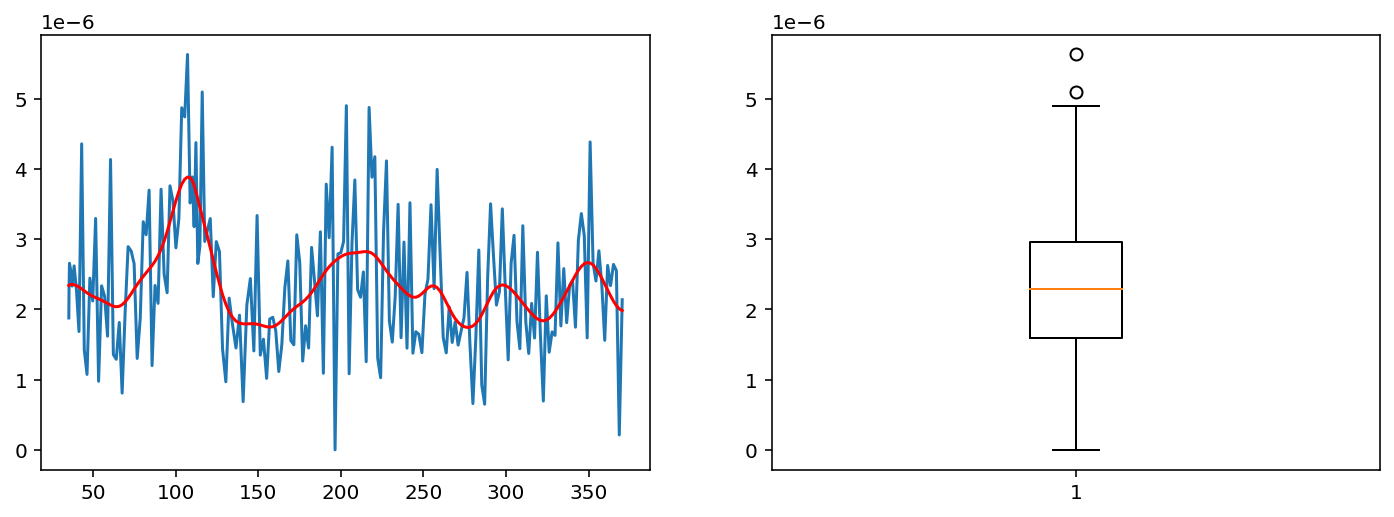

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
plt.subplot(1, 2, 1); plt.plot(htt['temp'], htt['abun_minsub_scaled'])
plt.subplot(1, 2, 1); plt.plot(htt['temp'], htt['abun_minsub_scaled_filtered'], color='red')
plt.subplot(1, 2, 2); plt.boxplot(htt['abun_minsub_scaled'])
plt.show()

In [18]:
ion_abund_median = htt['abun_minsub_scaled_filtered'].mean()
print(ion_abund_median)
peaks, _ = find_peaks(htt['abun_minsub_scaled_filtered'], prominence=ion_abund_median)
#peaks_s = find_peaks_cwt(htt['abun_minsub_scaled'], noise_perc=0.1)
print(f'Peak idx: {peaks}') # indexes where peaks are found
#print(f'Peak idx: {peaks_s}') # indexes where peaks are found
# Get temp values for peaks
for i in peaks:
    print(htt.iloc[i]['temp'])
    
# Compute area under the curve
#xx = htt['temp']
#yy = htt['abun_minsub_scaled']
#print(f'Area under the curve: {np.round(auc(xx,yy),5)}')

2.360300874910426e-06
Peak idx: []


In [19]:
# Computation for sample S0000
ion_peaks_cnt = {}

for ion in ion_list:
    ion_peaks_info = []
    temp_dt = ht[ht['m/z'] == ion].copy()
    temp_dt['abun_minsub_scaled_filtered'] = gaussian_filter1d(temp_dt['abun_minsub_scaled'], 
                                                               sigma=4)
    med = temp_dt['abun_minsub_scaled_filtered'].median()
    
    peaks, _ = find_peaks(temp_dt['abun_minsub_scaled_filtered'], prominence=med)
    ion_peaks_info.append(len(peaks))
    
    peak_temp = []
    peak_time = []
    peak_abund = []
    for i in peaks:
        tm = temp_dt.iloc[i]['time']; peak_time.append(tm) 
        t = temp_dt.iloc[i]['temp']; peak_temp.append(t)
        a = temp_dt.iloc[i]['abun_minsub_scaled']; peak_abund.append(a)
    
    if len(peak_time)>0 and len(peak_temp)>0 and len(peak_abund)>0:
        peak_time = max(peak_time)
        peak_temp = max(peak_temp)
        peak_abund = max(peak_abund)
    else: 
        peak_time, peak_temp, peak_abund = 0, 0, 0
        
    # Compute AUC
    if not temp_dt.empty:
        area_abund = np.round(auc(temp_dt['temp'],temp_dt['abun_minsub_scaled']),5)
    else: area_abund = 0
    
    # Add values
    ion_peaks_info.append(peak_time)
    ion_peaks_info.append(peak_temp)
    ion_peaks_info.append(peak_abund)
    ion_peaks_info.append(area_abund)
        
    ion_peaks_cnt[ion] = ion_peaks_info
    
ion_peaks_cnt

{0.0: [2, 1057.428, 211.921, 0.004470519521099676, 0.23782],
 1.0: [2, 1057.428, 211.921, 0.0038136619698634225, 0.21449],
 2.0: [2, 1077.961, 215.359, 0.0005123556598944679, 0.03806],
 3.0: [0, 0, 0, 0, 0.03961],
 5.0: [1, 441.332, 105.458, 2.7124405884896144e-05, 0.00385],
 6.0: [1, 431.06, 103.666, 2.6798565682232838e-06, 0.00084],
 7.0: [1, 420.772, 101.931, 4.246513336702777e-06, 0.0006],
 8.0: [0, 0, 0, 0, 0.00104],
 9.0: [0, 0, 0, 0, 0.00078],
 10.0: [0, 0, 0, 0, 0.00082],
 11.0: [0, 0, 0, 0, 0.00084],
 12.0: [2, 1796.886, 340.303, 0.00014395089424569068, 0.01731],
 13.0: [0, 0, 0, 0, 0.00402],
 14.0: [0, 0, 0, 0, 0.38302],
 15.0: [2, 1077.961, 215.359, 0.00023548035042686977, 0.01611],
 16.0: [2, 1057.428, 211.921, 0.024268038610332734, 1.2762],
 17.0: [2, 1057.428, 211.921, 0.2731880287813971, 13.32941],
 18.0: [2, 1057.428, 211.921, 0.9858801583853227, 48.16406],
 19.0: [2, 1088.232, 217.115, 0.006349436036159307, 0.46937],
 20.0: [2, 1057.428, 211.921, 0.002035174175259523, 

In [20]:
new_cols = ['m/z','peak_cnt', 'peak_time', 'peak_temp', 'peak_abund', 'abund_area']
ion_peaks_stats = pd.DataFrame(ion_peaks_cnt)
ion_peaks_stats = ion_peaks_stats.T
ion_peaks_stats.reset_index(inplace=True)
ion_peaks_stats.columns = new_cols
ion_peaks_stats['sample_id'] = 'S0000'
ion_peaks_stats

,m/z,peak_cnt,peak_time,peak_temp,peak_abund,abund_area,sample_id
0,0.0,2.0,1057.428,211.921,0.004471,0.23782,S0000
1,1.0,2.0,1057.428,211.921,0.003814,0.21449,S0000
2,2.0,2.0,1077.961,215.359,0.000512,0.03806,S0000
3,3.0,0.0,0.000,0.000,0.000000,0.03961,S0000
4,5.0,1.0,441.332,105.458,0.000027,0.00385,S0000
...,...,...,...,...,...,...,...
94,95.0,0.0,0.000,0.000,0.000000,0.00049,S0000
95,96.0,0.0,0.000,0.000,0.000000,0.00074,S0000
96,97.0,0.0,0.000,0.000,0.000000,0.00052,S0000
97,98.0,0.0,0.000,0.000,0.000000,0.00050,S0000


In [21]:
features.compute_ion_peaks(metadata, 0, ion_list)

peak_cnt                                               ...  \
m/z           0.0  1.0  2.0  3.0  5.0  6.0  7.0  8.0  9.0  10.0  ...   
sample_id                                                        ...   
S0000          2.0  2.0  2.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  ...   

          peak_abund                                               
m/z             90.0 91.0 92.0 93.0 94.0 95.0 96.0 97.0 98.0 99.0  
sample_id                                                          
S0000            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 396 columns]

In [22]:
file_paths = {A:N for (A,N) in [x for x in train_files.items()][:5]}
ita = features.features_ion_peaks(file_paths, metadata, ion_list)
ita

100%|██████████| 5/5 [00:00<00:00,  6.10it/s]


,peak_cnt_0.0,peak_cnt_1.0,peak_cnt_2.0,peak_cnt_3.0,peak_cnt_5.0,peak_cnt_6.0,peak_cnt_7.0,peak_cnt_8.0,peak_cnt_9.0,peak_cnt_10.0,...,peak_abund_90.0,peak_abund_91.0,peak_abund_92.0,peak_abund_93.0,peak_abund_94.0,peak_abund_95.0,peak_abund_96.0,peak_abund_97.0,peak_abund_98.0,peak_abund_99.0
sample_id,,,,,,,,,,,,,,,,,,,,,
S0000,2.0,2.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0002,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0003,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0004,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Abundance Peaks + Stats

In [32]:
# ===== TRAIN SAMPLE =====
fts_ion_peaks = features.features_ion_peaks(train_files, metadata, ion_list)
print(fts_ion_peaks.shape)
fts_ion_peaks.head()

100%|██████████| 766/766 [02:20<00:00,  5.43it/s]

(766, 396)


,peak_cnt_0.0,peak_cnt_1.0,peak_cnt_2.0,peak_cnt_3.0,peak_cnt_5.0,peak_cnt_6.0,peak_cnt_7.0,peak_cnt_8.0,peak_cnt_9.0,peak_cnt_10.0,...,peak_abund_90.0,peak_abund_91.0,peak_abund_92.0,peak_abund_93.0,peak_abund_94.0,peak_abund_95.0,peak_abund_96.0,peak_abund_97.0,peak_abund_98.0,peak_abund_99.0
sample_id,,,,,,,,,,,,,,,,,,,,,
S0000,2.0,2.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0002,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0003,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0004,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# ===== VALID & TEST SAMPLE =====
fts_ion_peaks_VT = features.features_ion_peaks(all_test_files, metadata, ion_list)
print(fts_ion_peaks_VT.shape)
fts_ion_peaks_VT.head()

100%|██████████| 804/804 [02:31<00:00,  5.32it/s]

(804, 396)


,peak_cnt_0.0,peak_cnt_1.0,peak_cnt_2.0,peak_cnt_3.0,peak_cnt_5.0,peak_cnt_6.0,peak_cnt_7.0,peak_cnt_8.0,peak_cnt_9.0,peak_cnt_10.0,...,peak_abund_90.0,peak_abund_91.0,peak_abund_92.0,peak_abund_93.0,peak_abund_94.0,peak_abund_95.0,peak_abund_96.0,peak_abund_97.0,peak_abund_98.0,peak_abund_99.0
sample_id,,,,,,,,,,,,,,,,,,,,,
S0766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0769,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0770,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**ANALYZE THE ABUNDANCE CURVE**

## Combine mx relative abundance and ion peaks

In [34]:
# ===== TRAIN SAMPLE =====
combo_maxabund_peaks = pd.concat([fts_maxrelabund_tempion, fts_ion_peaks], 
                               axis = 1, 
                               ignore_index=False)
print(combo_maxabund_peaks.shape)

(766, 1980)


In [35]:
# ===== VALID & TEST SAMPLE =====
combo_maxabund_peaks_VT = pd.concat([fts_maxrelabund_tempion_VT, fts_ion_peaks_VT], 
                               axis = 1, 
                               ignore_index=False)
print(combo_maxabund_peaks_VT.shape)

(804, 1980)


# MODELS

In [16]:
# Data frame to save local CV results
models_log_loss = pd.DataFrame(index=target_labels_list)

## Logistic Regression - Benchmark

In [89]:
train_cv_loss_LR, train_full_clf_LR, submission_LR = training.train_tbl(
    df_train=fts_maxrelabund_tempion,
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test=fts_maxrelabund_tempion_VT,
    model_algo='LR_reg',
    sub_name='LR_reg'
    )
models_log_loss['LR_reg'] = models_log_loss.index.map(train_cv_loss_LR)


Average Log Loss: 0.2759
Log Loss per Label:
{'basalt': 0.27678260590883075, 'carbonate': 0.2612545003933846, 'chloride': 0.2842979960325033, 'iron_oxide': 0.3824699336087238, 'oxalate': 0.004059239489520996, 'oxychlorine': 0.2991500982787292, 'phyllosilicate': 0.4074758334090647, 'silicate': 0.35168474392654814, 'sulfate': 0.34471883287139204, 'sulfide': 0.14713584783404984}


In [90]:
submission_LR.head()

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,1.868003e-07,0.000062,0.000004,1.125625e-07,0.000052,0.000090,8.296115e-08,0.998771,0.000002,0.000002
S0767,2.259753e-01,0.261281,0.007587,3.353358e-01,0.000132,0.226904,1.458527e-02,0.879255,0.057940,0.009740
S0768,5.743717e-01,0.508643,0.000804,2.181478e-01,0.000763,0.277165,8.997608e-01,0.685684,0.249768,0.002388
S0769,1.895572e-02,0.092020,0.042351,7.053178e-02,0.000083,0.977360,1.079748e-01,0.086535,0.370443,0.003093
S0770,8.417039e-04,0.008442,0.048491,3.099149e-01,0.000358,0.862539,5.699419e-01,0.003204,0.001448,0.019214


## XGB

- numerical data needs to be scaled
- categorical data needs to be encoded

In [20]:
train_cv_loss_XGB, train_full_clf_XGB, submission_XGB = training.train_tbl(
    df_train=fts_maxrelabund_tempion,
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test=fts_maxrelabund_tempion_VT,
    model_algo='XGB',
    sub_name='XGB'
    )
models_log_loss['XGB'] = models_log_loss.index.map(train_cv_loss_XGB)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1934
Log Loss per Label:
{'basalt': 0.22565078102787242, 'carbonate': 0.13225618815649615, 'chloride': 0.22720553328986837, 'iron_oxide': 0.254578396456081, 'oxalate': 0.027906252811262605, 'oxychlorine': 0.20850854126821824, 'phyllosilicate': 0.29730870486992084, 'silicate': 0.2575651139000811, 'sulfate': 0.2245971262183839, 'sulfide': 0.07831794841140914}


## XGB - optimized

- numerical data needs to be scaled
- categorical data needs to be encoded

In [91]:
train_cv_loss_XGB_opt, train_full_clf_XGB_opt, submission_XGB_opt = training.train_tbl(
    df_train=fts_maxrelabund_tempion,
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test=fts_maxrelabund_tempion_VT,
    model_algo='XGB_opt',
    sub_name='XGB_opt'
    )
models_log_loss['XGB_opt'] = models_log_loss.index.map(train_cv_loss_XGB_opt)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1746
Log Loss per Label:
{'basalt': 0.19665137401195665, 'carbonate': 0.12102018407547, 'chloride': 0.2043376334408594, 'iron_oxide': 0.22611550844240597, 'oxalate': 0.029272685140647313, 'oxychlorine': 0.19420209851804687, 'phyllosilicate': 0.25951556825253963, 'silicate': 0.23317893970805786, 'sulfate': 0.20317408057798922, 'sulfide': 0.07880694186687044}


In [92]:
submission_XGB_opt.head()

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0.002264,0.002201,0.003759,0.004286,0.001020,0.004258,0.008280,0.482346,0.005675,0.001228
S0767,0.099640,0.044188,0.001508,0.041713,0.000688,0.008322,0.019387,0.208535,0.017686,0.000710
S0768,0.342900,0.187369,0.001210,0.004061,0.001485,0.002831,0.251529,0.916730,0.016389,0.000994
S0769,0.001961,0.002187,0.019743,0.035369,0.000688,0.965160,0.030881,0.002617,0.932003,0.002146
S0770,0.003582,0.002337,0.002956,0.171626,0.001548,0.994668,0.959515,0.001145,0.003278,0.000646


## SVC

In [25]:
train_cv_loss_SVC, train_full_clf_SVC, submission_SVC = training.train_tbl(
    df_train=fts_maxrelabund_tempion,
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test=fts_maxrelabund_tempion_VT,
    model_algo='SVC',
    sub_name='SVC'
    )
models_log_loss['SVC'] = models_log_loss.index.map(train_cv_loss_SVC)


Average Log Loss: 0.2401
Log Loss per Label:
{'basalt': 0.25070777631129254, 'carbonate': 0.18702801899672405, 'chloride': 0.27881796952697535, 'iron_oxide': 0.35502919231069896, 'oxalate': 0.006768214729286988, 'oxychlorine': 0.2533807086878552, 'phyllosilicate': 0.3651507224370013, 'silicate': 0.2933434388817902, 'sulfate': 0.292882412195418, 'sulfide': 0.11754173393741038}


## XGBoost - duration

In [36]:
train_cv_loss_XGB_dur, train_full_clf_XGB_dur, submission_XGB_dur = training.train_tbl(
    df_train=fts_dur_maxabund_ion,
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test=fts_dur_maxabund_ion_VT,
    model_algo='XGB',
    sub_name='XGB'
    )
models_log_loss['XGB_dur'] = models_log_loss.index.map(train_cv_loss_XGB_dur)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.2984
Log Loss per Label:
{'basalt': 0.34556434985473283, 'carbonate': 0.3039762745213908, 'chloride': 0.35030911804592496, 'iron_oxide': 0.3612019024268693, 'oxalate': 0.054180436207662774, 'oxychlorine': 0.25880992177133333, 'phyllosilicate': 0.4233393864763624, 'silicate': 0.4181880998372816, 'sulfate': 0.3117083685347533, 'sulfide': 0.15627469664609736}


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


## XGBoost - combo

In [37]:
train_cv_loss_XGB_c_maxa_dur, train_full_clf_XGB_c_maxa_dur, submission_XGB_c_maxa_dur = training.train_tbl(
    df_train=combo_maxabund_dur,
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test=combo_maxabund_dur_VT,
    model_algo='XGB',
    sub_name='XGB'
    )
models_log_loss['XGB_c_maxa_dur'] = models_log_loss.index.map(train_cv_loss_XGB_c_maxa_dur)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.2088
Log Loss per Label:
{'basalt': 0.25283269836521766, 'carbonate': 0.1568007914775074, 'chloride': 0.2324278729797448, 'iron_oxide': 0.2708302561882614, 'oxalate': 0.026917641104946738, 'oxychlorine': 0.19666697024059704, 'phyllosilicate': 0.30996859815454475, 'silicate': 0.30714183883599977, 'sulfate': 0.25002698590957995, 'sulfide': 0.08430427635356989}


## XGBoost - Ion peaks

In [38]:
train_cv_loss_XGB_peaks, train_full_clf_XGB_peaks, submission_XGB_peaks = training.train_tbl(
    df_train=fts_ion_peaks,
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test=fts_ion_peaks_VT,
    model_algo='XGB',
    sub_name='XGB'
    )
models_log_loss['XGB_peaks'] = models_log_loss.index.map(train_cv_loss_XGB_peaks)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.2168
Log Loss per Label:
{'basalt': 0.2662005066700371, 'carbonate': 0.15578550758446205, 'chloride': 0.2279696334350056, 'iron_oxide': 0.28814666525320687, 'oxalate': 0.02202209493447068, 'oxychlorine': 0.20259409291290642, 'phyllosilicate': 0.3358335958875466, 'silicate': 0.2946318480355391, 'sulfate': 0.2899387708749964, 'sulfide': 0.08440535310957843}


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


## XGBoost - Temp bin + Ion peaks

In [39]:
train_cv_loss_XGB_tempb_peaks, train_full_clf_XGB_tempb_peaks, submission_XGB_tempb_peaks = training.train_tbl(
    df_train=combo_maxabund_peaks,
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test=combo_maxabund_peaks_VT,
    model_algo='XGB',
    sub_name='XGB'
    )
models_log_loss['XGB_tempb_peaks'] = models_log_loss.index.map(train_cv_loss_XGB_tempb_peaks)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1839
Log Loss per Label:
{'basalt': 0.22668344263328524, 'carbonate': 0.13014411018843777, 'chloride': 0.2109755146663402, 'iron_oxide': 0.25353649973288445, 'oxalate': 0.01147664093265209, 'oxychlorine': 0.17701662963923498, 'phyllosilicate': 0.2564108020572279, 'silicate': 0.26046270310180664, 'sulfate': 0.23697255192141126, 'sulfide': 0.0754287604499344}


## XGBoost opt - Temp bin + Ion peaks

In [102]:
train_cv_loss_XGB_tempb_peaks_opt, train_full_clf_XGB_tempb_peaks_opt, submission_XGB_tempb_peaks_opt = training.train_tbl(
    df_train=combo_maxabund_peaks,
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test=combo_maxabund_peaks_VT,
    model_algo='XGB_opt',
    sub_name='XGB_opt'
    )
models_log_loss['XGB_tempb_peaks_opt'] = models_log_loss.index.map(train_cv_loss_XGB_tempb_peaks_opt)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1707
Log Loss per Label:
{'basalt': 0.19504383100727152, 'carbonate': 0.12725561255970502, 'chloride': 0.20048671679044144, 'iron_oxide': 0.24008311371277063, 'oxalate': 0.012315083744781958, 'oxychlorine': 0.164854814627361, 'phyllosilicate': 0.2399570535617075, 'silicate': 0.23931971397608573, 'sulfate': 0.21280561231900258, 'sulfide': 0.07529303845939923}


In [103]:
submission_XGB_tempb_peaks_opt.head()

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0.002123,0.004970,0.003253,0.004333,0.000863,0.003197,0.006514,0.799322,0.003398,0.001778
S0767,0.024597,0.007265,0.000920,0.015660,0.000863,0.005500,0.004605,0.121936,0.022871,0.000727
S0768,0.434360,0.072563,0.000853,0.006407,0.001689,0.003432,0.135144,0.939239,0.030835,0.000634
S0769,0.004025,0.003047,0.005161,0.010979,0.000863,0.993456,0.011854,0.006675,0.065841,0.002423
S0770,0.004413,0.001155,0.003610,0.195763,0.001070,0.996430,0.976062,0.000976,0.004452,0.001012


***

## Model Summary

- Can we do different models per different target?

In [41]:
models_log_loss.style.highlight_min(axis=1, props='color:darkblue; background-color:lightblue;')

,LR_reg,XGB,XGB_opt,SVC,XGB_dur,XGB_c_maxa_dur,XGB_peaks,XGB_tempb_peaks,XGB_tempb_peaks_opt
basalt,0.276783,0.225651,0.196651,0.250708,0.345564,0.252833,0.266201,0.226683,0.195044
carbonate,0.261255,0.132256,0.121020,0.187028,0.303976,0.156801,0.155786,0.130144,0.127256
chloride,0.284298,0.227206,0.204338,0.278818,0.350309,0.232428,0.227970,0.210976,0.200487
iron_oxide,0.382470,0.254578,0.226116,0.355029,0.361202,0.270830,0.288147,0.253536,0.240083
oxalate,0.004059,0.027906,0.029273,0.006768,0.054180,0.026918,0.022022,0.011477,0.012315
oxychlorine,0.299150,0.208509,0.194202,0.253381,0.258810,0.196667,0.202594,0.177017,0.164855
phyllosilicate,0.407476,0.297309,0.259516,0.365151,0.423339,0.309969,0.335834,0.256411,0.239957
silicate,0.351685,0.257565,0.233179,0.293343,0.418188,0.307142,0.294632,0.260463,0.239320
sulfate,0.344719,0.224597,0.203174,0.292882,0.311708,0.250027,0.289939,0.236973,0.212806
sulfide,0.147136,0.078318,0.078807,0.117542,0.156275,0.084304,0.084405,0.075429,0.075293


In [42]:
models_log_loss.agg('mean').sort_values()

XGB_tempb_peaks_opt    0.170741
XGB_opt                0.174628
XGB_tempb_peaks        0.183911
XGB                    0.193389
XGB_c_maxa_dur         0.208792
XGB_peaks              0.216753
SVC                    0.240065
LR_reg                 0.275903
XGB_dur                0.298355
dtype: float64

# Predict Validation on Individual Labels

Compute predictions for each label depending on which model performed the best for that label. Validate the results on the validation sample only since we have the labels.

In [121]:
submission_by_label = pd.read_csv(config.DATA_DIR + 'submission_format.csv', 
                             index_col='sample_id')
submission_by_label = submission_by_label
print(submission_by_label.shape)

log_loss_ind_label = {}

for label in target_labels_list:
    if label == 'oxalate':
        submission_by_label[label] = submission_LR[label]
    elif label in ['carbonate', 'iron_oxide', 'silicate', 'sulfate']:
        submission_by_label[label] = submission_XGB_opt[label]
    else:
        submission_by_label[label] = submission_XGB_tempb_peaks_opt[label]
    
    # Compute log-loss
    ll = log_loss(valid_labels[label], submission_by_label.iloc[:valid_labels.shape[0]][label])
    log_loss_ind_label[label] = ll

models_log_loss['Ind_labels'] = models_log_loss.index.map(log_loss_ind_label)

submission_by_label.to_csv(config.MODELS_DIR + 'ind_label' + '.csv')

print(f'Average Log Loss: {np.mean(list(log_loss_ind_label.values()))}')
log_loss_ind_label

(804, 10)
Average Log Loss: 0.15643182801666303


{'basalt': 0.13031078681986263,
 'carbonate': 0.0973891174027763,
 'chloride': 0.18781681326631164,
 'iron_oxide': 0.30508353391387294,
 'oxalate': 0.007415226945737933,
 'oxychlorine': 0.16011232950640428,
 'phyllosilicate': 0.24001772800752888,
 'silicate': 0.15213770120553258,
 'sulfate': 0.21562710335758695,
 'sulfide': 0.06840793974101607}

In [119]:
submission_by_label.tail()

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S1565,0.046487,0.337855,0.034070,0.108605,0.069877,0.035157,0.007689,0.140228,0.008094,0.021103
S1566,0.011090,0.067778,0.004769,0.004846,0.000071,0.017374,0.087756,0.005926,0.083946,0.011372
S1567,0.024199,0.167448,0.010104,0.001514,0.000390,0.005611,0.020656,0.003359,0.021393,0.002589
S1568,0.025338,0.024485,0.010097,0.002279,0.001032,0.254403,0.363807,0.003484,0.006630,0.113221
S1569,0.060904,0.337855,0.024309,0.124953,0.004330,0.041716,0.012045,0.169667,0.007888,0.025694


In [110]:
models_log_loss.style.highlight_min(axis=1, props='color:darkblue; background-color:lightblue;')

,LR_reg,XGB,XGB_opt,SVC,XGB_dur,XGB_c_maxa_dur,XGB_peaks,XGB_tempb_peaks,XGB_tempb_peaks_opt,Ind_labels
basalt,0.276783,0.225651,0.196651,0.250708,0.345564,0.252833,0.266201,0.226683,0.195044,0.130311
carbonate,0.261255,0.132256,0.121020,0.187028,0.303976,0.156801,0.155786,0.130144,0.127256,0.097389
chloride,0.284298,0.227206,0.204338,0.278818,0.350309,0.232428,0.227970,0.210976,0.200487,0.187817
iron_oxide,0.382470,0.254578,0.226116,0.355029,0.361202,0.270830,0.288147,0.253536,0.240083,0.305084
oxalate,0.004059,0.027906,0.029273,0.006768,0.054180,0.026918,0.022022,0.011477,0.012315,0.007415
oxychlorine,0.299150,0.208509,0.194202,0.253381,0.258810,0.196667,0.202594,0.177017,0.164855,0.160112
phyllosilicate,0.407476,0.297309,0.259516,0.365151,0.423339,0.309969,0.335834,0.256411,0.239957,0.240018
silicate,0.351685,0.257565,0.233179,0.293343,0.418188,0.307142,0.294632,0.260463,0.239320,0.152138
sulfate,0.344719,0.224597,0.203174,0.292882,0.311708,0.250027,0.289939,0.236973,0.212806,0.215627
sulfide,0.147136,0.078318,0.078807,0.117542,0.156275,0.084304,0.084405,0.075429,0.075293,0.068408


# Predict SAM testbed samples

In [107]:
tr_sam = metadata[(metadata.split == 'train') & (metadata.instrument_type == 'sam_testbed')].copy()
print(tr_sam.shape)

(12, 5)
